<a href="https://colab.research.google.com/github/oshbocker/CAFA/blob/main/CAFA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"oshbocker","key":"bb9c6a60ba5c39e689d8cf8d15cb8bca"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install obonet -q
!pip install biopython -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 31.8 MB/s eta 0:00:00


In [ ]:
import os
import torch

from pathlib import Path


iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

cafa_main_path = Path("cafa-5-protein-function-prediction")
cafa_clean_fasta_path = Path("viktorfairuschin/cafa-5-fasta-files")
esm2_path = Path("viktorfairuschin/cafa-5-ems-2-embeddings-numpy")
protbert_path = Path("henriupton/protbert-embeddings-for-cafa5")
t5_path = Path("sergeifironov/t5embeds")

data_paths = [cafa_clean_fasta_path, esm2_path, protbert_path, t5_path]

if iskaggle:
  content_dir = "/kaggle/input"
else:
  content_dir = "/content"

class CFG:
    train_go_obo_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_seq_fasta_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    train_ia_path: str = f"{content_dir}/cafa-5-protein-function-prediction/IA.txt"
    test_sequences_path: str = f"{content_dir}/Test (Targets)/testsuperset.fasta"

    num_labels = 500
    n_epochs = 20
    batch_size = 128
    lr = 0.0005

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
if not iskaggle:
  import zipfile,kaggle
  if not cafa_main_path.exists():
    print(cafa_main_path)
    kaggle.api.competition_download_cli(str(cafa_main_path))
    zipfile.ZipFile(f'{cafa_main_path}.zip').extractall(cafa_main_path)
  for data_path in data_paths:
    if not data_path.exists():
      print(data_path)
      kaggle.api.dataset_download_files(str(data_path))
      zipfile.ZipFile(f'{data_path.name}.zip').extractall(data_path.name)

cafa-5-protein-function-prediction


100%|██████████| 115M/115M [00:07<00:00, 16.5MB/s]



viktorfairuschin/cafa-5-fasta-files
viktorfairuschin/cafa-5-ems-2-embeddings-numpy
henriupton/protbert-embeddings-for-cafa5
sergeifironov/t5embeds


In [ ]:
import obonet
import time

import networkx as nx
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [ ]:
graph = obonet.read_obo(CFG.train_go_obo_path)

In [ ]:
# Information Accretion values for terms
ia_dict = {}
with open(CFG.train_ia_path) as f:
    for line in f:
        (key, value) = line.split("\t")
        ia_dict[key] = float(value.replace("\n",""))

In [ ]:
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

BPO_len = len(nx.ancestors(graph, subontology_roots['BPO']))
CCO_len = len(nx.ancestors(graph, subontology_roots['CCO']))
MFO_len = len(nx.ancestors(graph, subontology_roots['MFO']))
print(BPO_len, CCO_len, MFO_len, BPO_len + CCO_len + MFO_len)

27941 4042 11262 43245


In [ ]:
train_terms = pd.read_csv(CFG.train_terms_path, sep="\t")
train_terms['ia'] = train_terms['term'].apply(lambda x: ia_dict[x])
print(train_terms.shape)
train_terms.head(10)

(5363863, 4)


,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A009IHW8,GO:0034655,BPO,0.042274
2,A0A009IHW8,GO:0072523,BPO,0.083901
3,A0A009IHW8,GO:0044270,BPO,0.281155
4,A0A009IHW8,GO:0006753,BPO,0.013844
5,A0A009IHW8,GO:1901292,BPO,0.000000
6,A0A009IHW8,GO:0044237,BPO,0.103670
7,A0A009IHW8,GO:1901360,BPO,1.237575
8,A0A009IHW8,GO:0008150,BPO,0.000000
9,A0A009IHW8,GO:1901564,BPO,0.557385


## Get the leaf predictions for each protein
A leaf prediction is a GO term that doesn't have any children that are also predictions for the protein.

In [ ]:
def get_leaf_labels(train_terms, aspect):
    # Group by protein and get a list of all go term predictions
    protein_list_go_term = train_terms[train_terms['aspect'] == aspect].groupby('EntryID')['term'].apply(list)

    leaf_labels = {}
    for i, protein in enumerate(protein_list_go_term.index):
        test_terms = set(protein_list_go_term[protein])
        descendants = set()
        for term in test_terms:
            descendants.update(nx.descendants(graph, term))

        specific_labels = test_terms.difference(descendants)
        leaf_labels[protein] = list(specific_labels)

    return leaf_labels

from collections import deque

# Get ordered list of all ancestors
def leaf_label_ancestors(graph, leaf_labels):
    ordered_edges_dict = {}
    for label in leaf_labels:
        # Get ancestors
        ordered_edges = deque()
        node_is_root = False
        prev_node_id = label
        while node_is_root == False:
            node = graph.nodes[prev_node_id]
            node_is_root = 'is_a' not in node
            if not node_is_root:
                prev_node_id = node['is_a'][0]
                ordered_edges.appendleft(prev_node_id)
        ordered_edges_dict[label] = ordered_edges

    return ordered_edges_dict

In [ ]:
CCO_leaf_labels = get_leaf_labels(train_terms, 'CCO')
print(len(CCO_leaf_labels.values()))
CCO_all_leaf_labels = np.unique(np.concatenate(list(CCO_leaf_labels.values())))
print(len(CCO_all_leaf_labels))
CCO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'cellular_component']
CCO_ordered_edges = leaf_label_ancestors(graph, CCO_nodes)

92912
2763


In [ ]:
# Get the first node label
data_with_labels = []
# Get all CCO labeled proteins with leaf labels
for protein, label_list in CCO_leaf_labels.items():
    for label in label_list:
        data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': CCO_ordered_edges[label]})

In [ ]:
def get_next_label(rw, depth=1):
    if not rw['labeled'] and len(rw['ordered_edges']) > depth:
        return rw['ordered_edges'][-depth]
    else:
        return rw['balanced_label']

def is_final_balanced_label(rw, balanced_labels, depth=1):
    if not rw['labeled']:
        return (rw['balanced_label'] in balanced_labels) or (len(rw['ordered_edges']) == depth)
    else:
        return True

def get_balanced_labels(label_df, label_count_threshold):
    df = label_df.copy()
    balanced_labels = set([label for label, count in df['label'].value_counts().items()
                           if count >= label_count_threshold])
    df['labeled'] = df['label'].apply(lambda x: x in balanced_labels)
    df['balanced_label'] = df['label'] # df.apply(lambda x: x['label'] if x['labeled'] == True else None, axis=1)
    print(sum(df['labeled'])/df.shape[0])
    print(len(balanced_labels))
    print(df['balanced_label'].value_counts())
    depth = 1
    while sum(df['labeled'])/df.shape[0] < 1:
        df['balanced_label'] = df.apply(lambda x: get_next_label(x, depth=depth), axis=1)
        balanced_labels = set([label for label, count in df['balanced_label'].value_counts().items()
                                   if count >= label_count_threshold])
        df['labeled'] = df.apply(lambda x: is_final_balanced_label(x, balanced_labels, depth=depth), axis=1)
        depth += 1
        print(sum(df['labeled'])/df.shape[0])
        print(len(balanced_labels))
        print(df['balanced_label'].value_counts())

    return df

In [ ]:
CCO_df = pd.DataFrame(data_with_labels)

new_CCO_df = get_balanced_labels(CCO_df, 500)

0.612107597944911
47
GO:0005829    16981
GO:0005634    12661
GO:0005886    11509
GO:0005737     8335
GO:0005654     8160
              ...  
GO:1990332        1
GO:0009316        1
GO:0099571        1
GO:0044186        1
GO:0071202        1
Name: balanced_label, Length: 2763, dtype: int64
0.7935857682819184
65
GO:0005829    16981
GO:0005634    12725
GO:0005886    11823
GO:0110165    10149
GO:0005737     8406
              ...  
GO:0035449        1
GO:0044174        1
GO:0005879        1
GO:0044384        1
GO:0098539        1
Name: balanced_label, Length: 690, dtype: int64
0.9047031663762081
71
GO:0005829    17050
GO:0110165    14188
GO:0005634    12910
GO:0005886    11823
GO:0005737     8418
              ...  
GO:0031252        1
GO:0032994        1
GO:0035448        1
GO:0033176        1
GO:1990077        1
Name: balanced_label, Length: 294, dtype: int64
0.961806577190322
72
GO:0005829    17050
GO:0110165    16038
GO:0005634    12938
GO:0005886    11823
GO:0005737     8420
         

## Classify selected nodes of CCO

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
ohe_CCO_df = pd.get_dummies(new_CCO_df, prefix=['balanced_label'], columns=['balanced_label'], drop_first=True)
label_cols = [c for c in ohe_CCO_df.columns if 'balanced_label_' in c]
label_df = ohe_CCO_df.groupby('protein').sum(numeric_only=True)[label_cols].clip(0,1)
label_values = list(label_df.values)
label_ids = list(label_df.index)
labels_df = pd.DataFrame(data={"EntryID": label_ids, "labels_vect": label_values})

# Split into train, val, test
# X_train, X_test, y_train, y_test = train_test_split(label_ids,
#                                                     label_values,
#                                                     test_size = 0.2)
# print("Train label", len(y_train))
# print("Test label", len(y_test))

Train label 74329
Test label 18583


In [ ]:
# Directories for the different embedding vectors :
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "ESM2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "ESM2" : 1280,
    "Concat": 1024+1024,
}

In [ ]:
class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype

        if embeddings_source in ["ProtBERT", "ESM2"]:
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "T5":
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "Concat":
            bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
            bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
            esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
            esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
            t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
            t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")
            embeds = np.concatenate([bert_embeds, t5_embeds], axis=1)
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": t5_ids, "embed" : embeds_list})
        else:
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})


        if datatype=="train":
            self.df = self.df.merge(labels_df, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [ ]:
datatype = "train"
bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")

In [ ]:
bert_embeds.shape

(142246, 1024)

In [ ]:
np.concatenate([bert_embeds, t5_embeds], axis=1).shape

(142246, 2048)

In [ ]:
print(bert_ids[:5])
print(esm2_ids[:5])
print(t5_ids[:5])

['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']
['Q9ZSA8' 'P25353' 'A0A2R8YCW8' 'G3V5N8' 'A0A140LFN4']
['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']


In [ ]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 4*1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4*1012, 4*712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(4*712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x


class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):

    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)

    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=CFG.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=CFG.num_labels).to(CFG.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=CFG.num_labels).to(CFG.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=CFG.num_labels).to(CFG.device)
    n_epochs = CFG.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]

    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)

        ## VALIDATION PHASE :
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)

        scheduler.step(avg_loss)
        print("\n")

    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

    return model, losses_history, scores_history

In [ ]:
train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = "ESM2")
CFG.num_labels = train_dataset[0][1].shape[0]

In [ ]:
cat_model, cat_losses,cat_scores = train_model(embeddings_source="Concat",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:16<00:00, 39.99it/s]


Running Average TRAIN Loss :  5.545166027290741
Running Average TRAIN F1-Score :  0.09582354257378829
Running Average VAL Loss :  5.239930577474098
Running Average VAL F1-Score :  0.10879770819454977


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 47.10it/s]


Running Average TRAIN Loss :  5.089897868830129
Running Average TRAIN F1-Score :  0.12168551074620051
Running Average VAL Loss :  5.098583417396023
Running Average VAL F1-Score :  0.1212752715569653


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 47.98it/s]


Running Average TRAIN Loss :  4.9255947847978785
Running Average TRAIN F1-Score :  0.1349065764963809
Running Average VAL Loss :  4.963403695250211
Running Average VAL F1-Score :  0.13564468420123402


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 47.63it/s]


Running Average TRAIN Loss :  4.7852013388175845
Running Average TRAIN F1-Score :  0.14493168696806702
Running Average VAL Loss :  4.9039269832715595
Running Average VAL F1-Score :  0.14400518267122034


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 47.39it/s]


Running Average TRAIN Loss :  4.657411544694813
Running Average TRAIN F1-Score :  0.15459505929996115
Running Average VAL Loss :  4.845578536595384
Running Average VAL F1-Score :  0.15033762646864537


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 47.52it/s]


Running Average TRAIN Loss :  4.5270781819608965
Running Average TRAIN F1-Score :  0.1649796048048257
Running Average VAL Loss :  4.81143679030954
Running Average VAL F1-Score :  0.15852145105600357


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 48.10it/s]


Running Average TRAIN Loss :  4.401632846677704
Running Average TRAIN F1-Score :  0.17514640309303908
Running Average VAL Loss :  4.795050056013342
Running Average VAL F1-Score :  0.16569860197909891


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 47.50it/s]


Running Average TRAIN Loss :  4.270980655964726
Running Average TRAIN F1-Score :  0.18633019099359482
Running Average VAL Loss :  4.799561121692396
Running Average VAL F1-Score :  0.1715377534497274


EPOCH  9


100%|██████████| 654/654 [00:14<00:00, 46.47it/s]


Running Average TRAIN Loss :  4.137000525763275
Running Average TRAIN F1-Score :  0.19788648213177282
Running Average VAL Loss :  4.7958225909977745
Running Average VAL F1-Score :  0.17787074267047726


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 48.00it/s]


Running Average TRAIN Loss :  3.8039920111314967
Running Average TRAIN F1-Score :  0.2117982915622561
Running Average VAL Loss :  4.723884755617951
Running Average VAL F1-Score :  0.18620226603664763


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 48.68it/s]


Running Average TRAIN Loss :  3.72912749529614
Running Average TRAIN F1-Score :  0.21640000364740325
Running Average VAL Loss :  4.72567441692091
Running Average VAL F1-Score :  0.1860875950692451


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 48.44it/s]


Running Average TRAIN Loss :  3.686535175058091
Running Average TRAIN F1-Score :  0.21943247883327147
Running Average VAL Loss :  4.724595729618857
Running Average VAL F1-Score :  0.18684750040100045


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 49.05it/s]


Running Average TRAIN Loss :  3.6314346739276107
Running Average TRAIN F1-Score :  0.22171075320845351
Running Average VAL Loss :  4.7331189913292455
Running Average VAL F1-Score :  0.19003994497534346


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 48.11it/s]


Running Average TRAIN Loss :  3.6256521087174023
Running Average TRAIN F1-Score :  0.22341409626357053
Running Average VAL Loss :  4.728352465041696
Running Average VAL F1-Score :  0.18834805856012318


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 48.64it/s]


Running Average TRAIN Loss :  3.6160184250694534
Running Average TRAIN F1-Score :  0.22331166957769918
Running Average VAL Loss :  4.73056530299252
Running Average VAL F1-Score :  0.18941796152559046


EPOCH  16


100%|██████████| 654/654 [00:13<00:00, 48.22it/s]


Running Average TRAIN Loss :  3.6165547651617533
Running Average TRAIN F1-Score :  0.22375900676582203
Running Average VAL Loss :  4.7321474748115016
Running Average VAL F1-Score :  0.1901540170385413


EPOCH  17


100%|██████████| 654/654 [00:13<00:00, 47.15it/s]


Running Average TRAIN Loss :  3.6148566795051646
Running Average TRAIN F1-Score :  0.22350972852119977
Running Average VAL Loss :  4.735517848027896
Running Average VAL F1-Score :  0.18938011400503654


EPOCH  18


100%|██████████| 654/654 [00:13<00:00, 48.07it/s]


Running Average TRAIN Loss :  3.6151650848738646
Running Average TRAIN F1-Score :  0.22330217633043226
Running Average VAL Loss :  4.727958587750996
Running Average VAL F1-Score :  0.19084937196888335


EPOCH  19


100%|██████████| 654/654 [00:13<00:00, 48.50it/s]


Running Average TRAIN Loss :  3.6143957759262224
Running Average TRAIN F1-Score :  0.22370085172605805
Running Average VAL Loss :  4.73603683628448
Running Average VAL F1-Score :  0.19060051522842825


EPOCH  20


100%|██████████| 654/654 [00:13<00:00, 48.04it/s]


Running Average TRAIN Loss :  3.614737290125739
Running Average TRAIN F1-Score :  0.2236373680629497
Running Average VAL Loss :  4.731059022145729
Running Average VAL F1-Score :  0.1892646789959032


TRAINING FINISHED
FINAL TRAINING SCORE :  0.2236373680629497
FINAL VALIDATION SCORE :  0.1892646789959032


In [ ]:
esm2_model, esm2_losses, esm2_scores = train_model(embeddings_source="ESM2",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:12<00:00, 52.14it/s]


Running Average TRAIN Loss :  5.545578141460361
Running Average TRAIN F1-Score :  0.09913053967070051
Running Average VAL Loss :  5.108647895185915
Running Average VAL F1-Score :  0.1147561713236652


EPOCH  2


100%|██████████| 654/654 [00:12<00:00, 52.08it/s]


Running Average TRAIN Loss :  5.128735861647019
Running Average TRAIN F1-Score :  0.12621988464340522
Running Average VAL Loss :  4.962376392050965
Running Average VAL F1-Score :  0.13286239735475958


EPOCH  3


100%|██████████| 654/654 [00:12<00:00, 53.35it/s]


Running Average TRAIN Loss :  4.940879307755637
Running Average TRAIN F1-Score :  0.14069614761056157
Running Average VAL Loss :  4.874879497371308
Running Average VAL F1-Score :  0.13983722204623156


EPOCH  4


100%|██████████| 654/654 [00:12<00:00, 53.48it/s]


Running Average TRAIN Loss :  4.775984905910784
Running Average TRAIN F1-Score :  0.15383921745902537
Running Average VAL Loss :  4.791860090543146
Running Average VAL F1-Score :  0.15142157081871815


EPOCH  5


100%|██████████| 654/654 [00:12<00:00, 51.21it/s]


Running Average TRAIN Loss :  4.619815618620006
Running Average TRAIN F1-Score :  0.16681849997524822
Running Average VAL Loss :  4.734265660586423
Running Average VAL F1-Score :  0.1533142536470335


EPOCH  6


100%|██████████| 654/654 [00:12<00:00, 52.15it/s]


Running Average TRAIN Loss :  4.45334329809253
Running Average TRAIN F1-Score :  0.18026676033523834
Running Average VAL Loss :  4.699103116989136
Running Average VAL F1-Score :  0.16213372870259088


EPOCH  7


100%|██████████| 654/654 [00:12<00:00, 52.55it/s]


Running Average TRAIN Loss :  4.28749944274214
Running Average TRAIN F1-Score :  0.19464179515747485
Running Average VAL Loss :  4.664919572333767
Running Average VAL F1-Score :  0.17568793219246276


EPOCH  8


100%|██████████| 654/654 [00:12<00:00, 52.19it/s]


Running Average TRAIN Loss :  4.117517753478584
Running Average TRAIN F1-Score :  0.21018245203323685
Running Average VAL Loss :  4.658080336165755
Running Average VAL F1-Score :  0.17810573908564162


EPOCH  9


100%|██████████| 654/654 [00:12<00:00, 51.90it/s]


Running Average TRAIN Loss :  3.948776304175001
Running Average TRAIN F1-Score :  0.2261431053827662
Running Average VAL Loss :  4.675903610987206
Running Average VAL F1-Score :  0.19249204188993532


EPOCH  10


100%|██████████| 654/654 [00:12<00:00, 51.85it/s]


Running Average TRAIN Loss :  3.782157161549326
Running Average TRAIN F1-Score :  0.24309164686669632
Running Average VAL Loss :  4.67801286423043
Running Average VAL F1-Score :  0.19724666888583198


EPOCH  11


100%|██████████| 654/654 [00:12<00:00, 52.08it/s]


Running Average TRAIN Loss :  3.3689134638608413
Running Average TRAIN F1-Score :  0.26465287626883305
Running Average VAL Loss :  4.657415723147458
Running Average VAL F1-Score :  0.20727627938740875


EPOCH  12


100%|██████████| 654/654 [00:12<00:00, 52.18it/s]


Running Average TRAIN Loss :  3.270042424172801
Running Average TRAIN F1-Score :  0.2728920571209823
Running Average VAL Loss :  4.669719653586819
Running Average VAL F1-Score :  0.20951438929936658


EPOCH  13


100%|██████████| 654/654 [00:12<00:00, 51.41it/s]


Running Average TRAIN Loss :  3.21956653040848
Running Average TRAIN F1-Score :  0.27865609911694805
Running Average VAL Loss :  4.684608975501909
Running Average VAL F1-Score :  0.21174411720609013


EPOCH  14


100%|██████████| 654/654 [00:12<00:00, 52.27it/s]


Running Average TRAIN Loss :  3.1535016637329663
Running Average TRAIN F1-Score :  0.28394280266962285
Running Average VAL Loss :  4.687724061208229
Running Average VAL F1-Score :  0.21244328887495276


EPOCH  15


100%|██████████| 654/654 [00:12<00:00, 50.45it/s]


Running Average TRAIN Loss :  3.1439243504031356
Running Average TRAIN F1-Score :  0.28556402250896534
Running Average VAL Loss :  4.693231984360577
Running Average VAL F1-Score :  0.21561028961449452


EPOCH  16


100%|██████████| 654/654 [00:12<00:00, 51.87it/s]


Running Average TRAIN Loss :  3.1360045737082807
Running Average TRAIN F1-Score :  0.2857985546191533
Running Average VAL Loss :  4.6930273624315655
Running Average VAL F1-Score :  0.21549098214058027


EPOCH  17


100%|██████████| 654/654 [00:12<00:00, 51.42it/s]


Running Average TRAIN Loss :  3.135296452665183
Running Average TRAIN F1-Score :  0.2867678191501431
Running Average VAL Loss :  4.695975104423418
Running Average VAL F1-Score :  0.21420261243434802


EPOCH  18


100%|██████████| 654/654 [00:12<00:00, 51.71it/s]


Running Average TRAIN Loss :  3.133976500333267
Running Average TRAIN F1-Score :  0.28588401799628493
Running Average VAL Loss :  4.698350436066928
Running Average VAL F1-Score :  0.212846892949653


EPOCH  19


100%|██████████| 654/654 [00:12<00:00, 52.91it/s]


Running Average TRAIN Loss :  3.134782487463878
Running Average TRAIN F1-Score :  0.2859657310883569
Running Average VAL Loss :  4.690958104721488
Running Average VAL F1-Score :  0.213524973147536


EPOCH  20


100%|██████████| 654/654 [00:12<00:00, 53.38it/s]


Running Average TRAIN Loss :  3.134247322694971
Running Average TRAIN F1-Score :  0.28575169844182624
Running Average VAL Loss :  4.695763692463914
Running Average VAL F1-Score :  0.2145025281056966


TRAINING FINISHED
FINAL TRAINING SCORE :  0.28575169844182624
FINAL VALIDATION SCORE :  0.2145025281056966


In [ ]:
# Weighted F1 Score?

In [ ]:
t5_model, t5_losses, t5_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:13<00:00, 49.54it/s]


Running Average TRAIN Loss :  5.391881563612445
Running Average TRAIN F1-Score :  0.10728233756742438
Running Average VAL Loss :  5.120198582949704
Running Average VAL F1-Score :  0.126314373253143


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 49.07it/s]


Running Average TRAIN Loss :  4.930385328943212
Running Average TRAIN F1-Score :  0.13590293681812943
Running Average VAL Loss :  4.935800140851165
Running Average VAL F1-Score :  0.14302804708889086


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 48.59it/s]


Running Average TRAIN Loss :  4.712304858621836
Running Average TRAIN F1-Score :  0.15320310021668035
Running Average VAL Loss :  4.821727471808865
Running Average VAL F1-Score :  0.15393989155553792


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 49.90it/s]


Running Average TRAIN Loss :  4.513678512442002
Running Average TRAIN F1-Score :  0.1672668613789643
Running Average VAL Loss :  4.774706784993002
Running Average VAL F1-Score :  0.16716847170705665


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 48.98it/s]


Running Average TRAIN Loss :  4.313029373093118
Running Average TRAIN F1-Score :  0.1836799532175064
Running Average VAL Loss :  4.704157561472018
Running Average VAL F1-Score :  0.1775154910267216


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 47.94it/s]


Running Average TRAIN Loss :  4.1158644693707105
Running Average TRAIN F1-Score :  0.19977936777499838
Running Average VAL Loss :  4.676792961277374
Running Average VAL F1-Score :  0.19051970929315645


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 47.64it/s]


Running Average TRAIN Loss :  3.91944335542323
Running Average TRAIN F1-Score :  0.2175443580072225
Running Average VAL Loss :  4.681021772018851
Running Average VAL F1-Score :  0.19774443258161414


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 48.74it/s]


Running Average TRAIN Loss :  3.7245729206534337
Running Average TRAIN F1-Score :  0.23428892944611907
Running Average VAL Loss :  4.698496932852758
Running Average VAL F1-Score :  0.20567471442157276


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 48.59it/s]


Running Average TRAIN Loss :  3.311537489613991
Running Average TRAIN F1-Score :  0.2566723514815354
Running Average VAL Loss :  4.680388643317027
Running Average VAL F1-Score :  0.2158855340660435


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 48.07it/s]


Running Average TRAIN Loss :  3.2136653399248734
Running Average TRAIN F1-Score :  0.2666549575985025
Running Average VAL Loss :  4.700272217188796
Running Average VAL F1-Score :  0.21853046956127636


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 48.38it/s]


Running Average TRAIN Loss :  3.1408818015993916
Running Average TRAIN F1-Score :  0.2725176625295517
Running Average VAL Loss :  4.709671386300701
Running Average VAL F1-Score :  0.2209518804942092


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 48.77it/s]


Running Average TRAIN Loss :  3.1314810262907535
Running Average TRAIN F1-Score :  0.27383447092151786
Running Average VAL Loss :  4.709579072586478
Running Average VAL F1-Score :  0.22223915914966635


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 48.95it/s]


Running Average TRAIN Loss :  3.1255561878921787
Running Average TRAIN F1-Score :  0.27428474675989295
Running Average VAL Loss :  4.720775388691523
Running Average VAL F1-Score :  0.2225228778711737


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 48.97it/s]


Running Average TRAIN Loss :  3.123585212121316
Running Average TRAIN F1-Score :  0.2743871821722853
Running Average VAL Loss :  4.71714700084843
Running Average VAL F1-Score :  0.22156868303475313


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 48.91it/s]


Running Average TRAIN Loss :  3.122999621822929
Running Average TRAIN F1-Score :  0.2751003884303096
Running Average VAL Loss :  4.7068891296648
Running Average VAL F1-Score :  0.22293017069770865


EPOCH  16


100%|██████████| 654/654 [00:13<00:00, 49.05it/s]


Running Average TRAIN Loss :  3.1225910653397215
Running Average TRAIN F1-Score :  0.2751321818349194
Running Average VAL Loss :  4.713024622773471
Running Average VAL F1-Score :  0.22479567176675144


EPOCH  17


100%|██████████| 654/654 [00:13<00:00, 48.73it/s]


Running Average TRAIN Loss :  3.122622440714355
Running Average TRAIN F1-Score :  0.2746453193850838
Running Average VAL Loss :  4.712310170474118
Running Average VAL F1-Score :  0.22045137763839878


EPOCH  18


100%|██████████| 654/654 [00:13<00:00, 49.56it/s]


Running Average TRAIN Loss :  3.123021625232988
Running Average TRAIN F1-Score :  0.2747608718066405
Running Average VAL Loss :  4.717368573358614
Running Average VAL F1-Score :  0.2222299136935848


EPOCH  19


100%|██████████| 654/654 [00:13<00:00, 48.97it/s]


Running Average TRAIN Loss :  3.1218654103235366
Running Average TRAIN F1-Score :  0.27436981122336984
Running Average VAL Loss :  4.713330200273696
Running Average VAL F1-Score :  0.22204061097478214


EPOCH  20


100%|██████████| 654/654 [00:13<00:00, 49.24it/s]


Running Average TRAIN Loss :  3.1233980991060215
Running Average TRAIN F1-Score :  0.27492414891081846
Running Average VAL Loss :  4.714998114598941
Running Average VAL F1-Score :  0.22153358304337278


TRAINING FINISHED
FINAL TRAINING SCORE :  0.27492414891081846
FINAL VALIDATION SCORE :  0.22153358304337278


In [ ]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:13<00:00, 48.04it/s]


Running Average TRAIN Loss :  5.380510315618019
Running Average TRAIN F1-Score :  0.10960810876163776
Running Average VAL Loss :  5.109397267642087
Running Average VAL F1-Score :  0.12574740468639217


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 48.65it/s]


Running Average TRAIN Loss :  4.926471546884706
Running Average TRAIN F1-Score :  0.13879448299606642
Running Average VAL Loss :  4.936730339102549
Running Average VAL F1-Score :  0.14099581172204997


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 49.77it/s]


Running Average TRAIN Loss :  4.7061055596086225
Running Average TRAIN F1-Score :  0.15502608758867334
Running Average VAL Loss :  4.861573310747539
Running Average VAL F1-Score :  0.15111770889122192


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 49.50it/s]


Running Average TRAIN Loss :  4.505582496296011
Running Average TRAIN F1-Score :  0.1709451983919202
Running Average VAL Loss :  4.769523088246176
Running Average VAL F1-Score :  0.1635119282219508


EPOCH  5


100%|██████████| 654/654 [00:12<00:00, 50.89it/s]


Running Average TRAIN Loss :  4.304399333962607
Running Average TRAIN F1-Score :  0.18600215409691545
Running Average VAL Loss :  4.738441186408474
Running Average VAL F1-Score :  0.17663144677469175


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 50.21it/s]


Running Average TRAIN Loss :  4.102145431603131
Running Average TRAIN F1-Score :  0.20444322639466792
Running Average VAL Loss :  4.717735715108375
Running Average VAL F1-Score :  0.1879320209973479


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 48.68it/s]


Running Average TRAIN Loss :  3.9035235187693837
Running Average TRAIN F1-Score :  0.221018301875584
Running Average VAL Loss :  4.729083799336054
Running Average VAL F1-Score :  0.1972589270301061


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 48.27it/s]


Running Average TRAIN Loss :  3.706835571049915
Running Average TRAIN F1-Score :  0.2383333632796547
Running Average VAL Loss :  4.7247714147175826
Running Average VAL F1-Score :  0.20196290436672837


EPOCH  9


100%|██████████| 654/654 [00:12<00:00, 50.33it/s]


Running Average TRAIN Loss :  3.2939880955109904
Running Average TRAIN F1-Score :  0.26217221694255094
Running Average VAL Loss :  4.71126947337634
Running Average VAL F1-Score :  0.21491242026629515


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 48.55it/s]


Running Average TRAIN Loss :  3.1949618850643846
Running Average TRAIN F1-Score :  0.27313968694173596
Running Average VAL Loss :  4.722400955957909
Running Average VAL F1-Score :  0.2181674297133537


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 48.41it/s]


Running Average TRAIN Loss :  3.141590927354422
Running Average TRAIN F1-Score :  0.2789647308283625
Running Average VAL Loss :  4.7536642355461645
Running Average VAL F1-Score :  0.2220972039519924


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 49.88it/s]


Running Average TRAIN Loss :  3.074884709597363
Running Average TRAIN F1-Score :  0.2843685946014314
Running Average VAL Loss :  4.753345411117762
Running Average VAL F1-Score :  0.22061685687058594


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 49.71it/s]


Running Average TRAIN Loss :  3.0678535171240475
Running Average TRAIN F1-Score :  0.28560246442891773
Running Average VAL Loss :  4.7567079426491095
Running Average VAL F1-Score :  0.22286882343357556


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 50.30it/s]


Running Average TRAIN Loss :  3.0601198385250314
Running Average TRAIN F1-Score :  0.2872270378725609
Running Average VAL Loss :  4.757319420984347
Running Average VAL F1-Score :  0.22308668351336702


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 49.34it/s]


Running Average TRAIN Loss :  3.059301207554085
Running Average TRAIN F1-Score :  0.2871069089717457
Running Average VAL Loss :  4.761035475012374
Running Average VAL F1-Score :  0.22559839854501698


EPOCH  16


100%|██████████| 654/654 [00:13<00:00, 49.11it/s]


Running Average TRAIN Loss :  3.0566206703856813
Running Average TRAIN F1-Score :  0.28700730822046233
Running Average VAL Loss :  4.752109883582755
Running Average VAL F1-Score :  0.22268347605450511


EPOCH  17


100%|██████████| 654/654 [00:13<00:00, 48.83it/s]


Running Average TRAIN Loss :  3.0571752841319513
Running Average TRAIN F1-Score :  0.2870185047342507
Running Average VAL Loss :  4.755090569796628
Running Average VAL F1-Score :  0.2227098425365474


EPOCH  18


100%|██████████| 654/654 [00:13<00:00, 48.97it/s]


Running Average TRAIN Loss :  3.0589638117256515
Running Average TRAIN F1-Score :  0.2874091645355254
Running Average VAL Loss :  4.762693166732788
Running Average VAL F1-Score :  0.22162108898979344


EPOCH  19


100%|██████████| 654/654 [00:13<00:00, 49.20it/s]


Running Average TRAIN Loss :  3.0573166173167916
Running Average TRAIN F1-Score :  0.28645808555026303
Running Average VAL Loss :  4.755567152206212
Running Average VAL F1-Score :  0.22045215372353383


EPOCH  20


100%|██████████| 654/654 [00:13<00:00, 49.44it/s]


Running Average TRAIN Loss :  3.0561429309553327
Running Average TRAIN F1-Score :  0.28685405428894434
Running Average VAL Loss :  4.7582635389615415
Running Average VAL F1-Score :  0.22245458156278688


TRAINING FINISHED
FINAL TRAINING SCORE :  0.28685405428894434
FINAL VALIDATION SCORE :  0.22245458156278688


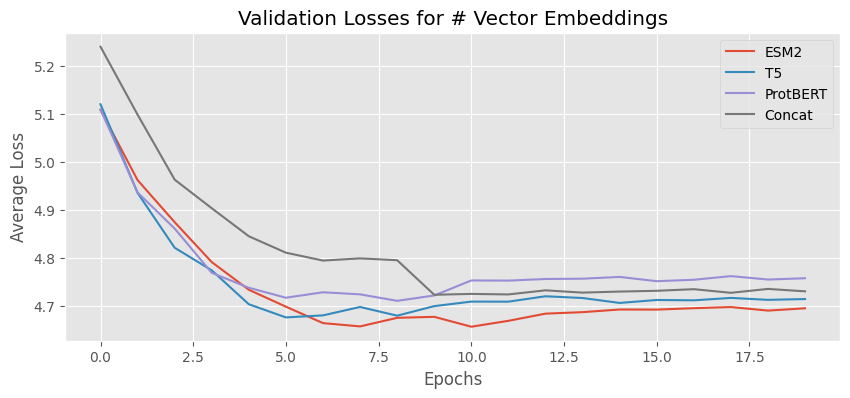

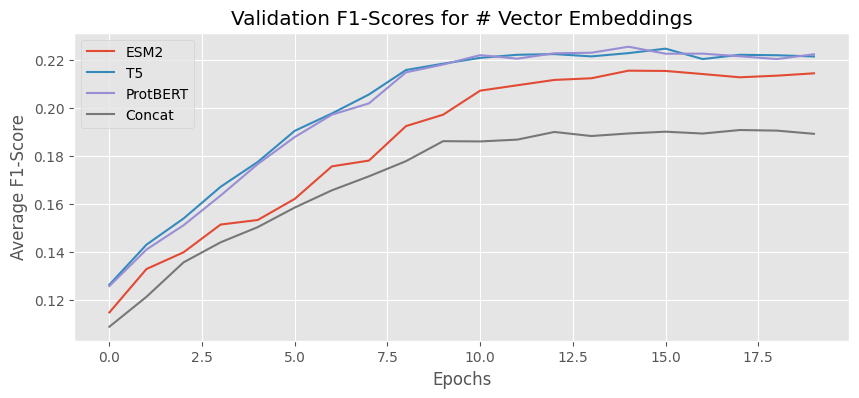

In [ ]:
plt.figure(figsize = (10, 4))
plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_losses["val"], label = "T5")
plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.plot(cat_losses["val"], label = "Concat")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_scores["val"], label = "T5")
plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.plot(cat_scores["val"], label = "Concat")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## Make Predictions

In [32]:
def predict(embeddings_source):

    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "ESM2":
        model = esm2_model
    if embeddings_source == "Concat":
        model = cat_model

    model.eval()

    labels = pd.read_csv(CFG.train_terms_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = [label.split('_')[-1] for label in label_cols]
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(CFG.device)
        confs_[i*CFG.num_labels:(i+1)*CFG.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*CFG.num_labels:(i+1)*CFG.num_labels] = id[0]
        go_terms_[i*CFG.num_labels:(i+1)*CFG.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [79]:
initial_submission_df = predict("ProtBERT")

GENERATE PREDICTION FOR TEST SET...


141865it [01:35, 1482.84it/s]


PREDICTIONS DONE


In [80]:
print(len(initial_submission_df))
print(len(initial_submission_df["GO term"].unique()))
initial_submission_df.head()

10356145
73


,Id,GO term,Confidence
0,Q9CQV8,GO:0000325,1.404903e-14
1,Q9CQV8,GO:0000785,9.830178e-16
2,Q9CQV8,GO:0005576,4.465114e-03
3,Q9CQV8,GO:0005615,8.910729e-04
4,Q9CQV8,GO:0005618,6.949610e-13


In [81]:
id_list = []
go_term_list = []
confidence_list = []
for rw in initial_submission_df.values:
  edges = CCO_ordered_edges[rw[1]]
  for edge in edges:
    id_list.append(rw[0])
    go_term_list.append(edge)
    confidence_list.append(rw[2])

In [82]:
additional_labels = pd.DataFrame({'Id': id_list, 'GO term': go_term_list, 'Confidence': confidence_list})

In [83]:
submission_df = pd.concat([initial_submission_df, additional_labels]).drop_duplicates(['Id', 'GO term']).reset_index(drop=True)

In [84]:
print(len(submission_df))
print(len(submission_df["GO term"].unique()))
submission_df.head()

15037584
106


,Id,GO term,Confidence
0,Q9CQV8,GO:0000325,1.404903e-14
1,Q9CQV8,GO:0000785,9.830178e-16
2,Q9CQV8,GO:0005576,4.465114e-03
3,Q9CQV8,GO:0005615,8.910729e-04
4,Q9CQV8,GO:0005618,6.949610e-13


In [85]:
submission_df['Id'].unique()[:5]

array(['Q9CQV8', 'P62259', 'P68510', 'P61982', 'O70456'], dtype=object)

In [86]:
protein_id = 'P68510'
subset_df = submission_df[submission_df['Id'] == protein_id].reset_index(drop=True)

In [87]:
subset_df.loc[subset_df['Confidence'].argmax()]

Id                P68510
GO term       GO:0005829
Confidence      0.999999
Name: 22, dtype: object

In [89]:
subset_df.sort_values(['Confidence'], ascending=False).head(7)

,Id,GO term,Confidence
22,P68510,GO:0005829,0.999999
68,P68510,GO:0110165,0.999804
24,P68510,GO:0005886,0.998719
49,P68510,GO:0043025,0.941316
96,P68510,GO:0044297,0.941316
79,P68510,GO:0031974,0.938896
13,P68510,GO:0005759,0.938896


In [75]:
train_terms[(train_terms['EntryID'] == protein_id) & (train_terms['aspect'] == 'CCO')]

,EntryID,term,aspect,ia
4032360,P68510,GO:0005622,CCO,0.366945
4032361,P68510,GO:0060076,CCO,4.520144
4032362,P68510,GO:0014704,CCO,0.525320
4032363,P68510,GO:0044291,CCO,3.752804
4032364,P68510,GO:0005575,CCO,0.000000
4032365,P68510,GO:0098984,CCO,2.297752
4032366,P68510,GO:0098978,CCO,1.802445
4032367,P68510,GO:0032279,CCO,0.102393
4032368,P68510,GO:0005829,CCO,1.545978
4032369,P68510,GO:0150048,CCO,1.415037


In [ ]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)